# Free Pass Data Science BCC 2021
Percobaan Ke tujuh

Sulthan Abiyyu Hakim | 05 Januari 2022

-----

## Deskripsi File

- train.csv - Data training yang berisi review beserta kategori sentimen review tersebut
- test.csv - Data uji yang berisi review yang harus Anda kategorikan
- sample_submission.csv - Contoh submission yang benar

## Penjelasan atribut dan kelas target
- id - Id unik setiap review
- review - Review yang diberikan pengguna
- jenis_review - Jenis dari review (0=review buruk, 1=review baik)


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [71]:
df_train = pd.read_csv('../data/train.csv')
df_test= pd.read_csv('../data/test.csv')

df_train.head(), df_test.head()

(                 id                                             review  \
 0  mnac5vg0i3mp5bdp  proses check-in kalau bisa lebih dipercepat ke...   
 1  1y7m90hp3wwok7fm  Kamar ga sesuai , ada bekas bocor dilangit2 , ...   
 2  suvdvwh580hmj8nz  Wifi nya aktif tapi tidak bisa di pakai...lele...   
 3  t07ma1ie3w29kqzy  breakfast harus selalu dikontrol, jangan sampa...   
 4  jcwq3gfdryrdbdx5  pelayanan ramah namun... tidak ada colokan, ai...   
 
    jenis_review  
 0             0  
 1             0  
 2             1  
 3             0  
 4             0  ,
                  id                                             review
 0  263aqhh4ymyaubmb      tv nya rusak.....kamar mandi kurang bersih...
 1  36frqq1ne0ljsgtj  SO BAD REALLY BAD VERY BAD BAD AND BAD RECEPTI...
 2  4dbq2twnu8nd9ztm  SANGAT MENGECEWAKAN. SAAT MASUK KAMAR, LANTAI ...
 3  hbsb134diyefkd3i                             Shower tidak berfungsi
 4  o068bc8hfiisuwon  privasi sangat minim karena suara kamar tetang...)

<AxesSubplot:>

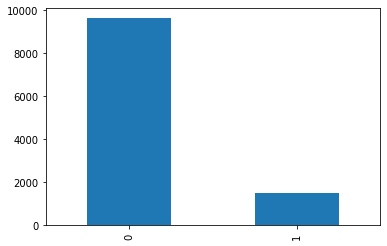

In [72]:
df_train["jenis_review"].value_counts().plot(kind='bar')

# Cleaning

In [95]:
# Cleaning
from string import punctuation
import re
def text_cleaning(data):
    # case folding
    data = data.lower()
    # remove punctuation
    data = re.sub('[^\w\s]',' ', data)
    # remove numbers
    data = re.sub('\d+','', data)
    # remove extra whitespace
    data = ' '.join(data.split())
    # remove emoji
    data = re.sub(r'[^\x00-\x7F]+',' ', data)
    # remove new line
    data = re.sub('\n',' ', data)

    return data

# Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
def stemmer_sastrawi(data):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    data = stemmer.stem(data)

    return data

# Stopword Removal
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
def stopword_removal(data):
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    data = stopword.remove(data)

    return data

# Bahasa alay removal
# Kamus alay
kamus_alay_1 = pd.read_csv(
    "https://raw.githubusercontent.com/ramaprakoso/analisis-sentimen/master/kamus/kbba.txt",
    delimiter="\t",
    header=None,
    names=['slang', 'formal'])
kamus_alay_2 = pd.read_csv(
    "https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv",
    usecols=["slang", "formal"])

kamus_alay = pd.concat([kamus_alay_1, kamus_alay_2])

# Dictionary bahasa alay
dict_alay = dict()
for index, row in kamus_alay.iterrows():
    dict_alay[row['slang']] = row['formal']

from nltk import word_tokenize
def normalize_text(data):
    word_tokens = word_tokenize(data)
    result = [dict_alay.get(w, w) for w in word_tokens]
    return ' '.join(result)

def preprocessing(data):
    data = text_cleaning(data)
    data = normalize_text(data)
    data = stemmer_sastrawi(data)
    data = stopword_removal(data)
    return data

In [97]:
from tqdm.auto import tqdm
tqdm.pandas()

df_train['review'] = df_train['review'].progress_apply(preprocessing)
df_train.head()

100%|██████████| 11142/11142 [00:50<00:00, 221.05it/s]


,id,review,jenis_review
0,mnac5vg0i3mp5bdp,proses check cepat kemarin tunggu jam an pas c...,0
1,1y7m90hp3wwok7fm,kamar sesuai bekas bocor langit seprei lusuh k...,0
2,suvdvwh580hmj8nz,wifi aktif pakai lambat tolong wifi biar langs...,1
3,t07ma1ie3w29kqzy,breakfast kontrol makan habis bersih kamar hot...,0
4,jcwq3gfdryrdbdx5,layan ramah colok air nyamuk sarang lemari,0


In [102]:
tqdm.pandas()

df_test['review'] = df_test['review'].progress_apply(preprocessing)
df_test.head(10)

100%|██████████| 3714/3714 [00:16<00:00, 219.91it/s]


,id,review
0,263aqhh4ymyaubmb,tv rusak kamar mandi bersih
1,36frqq1ne0ljsgtj,sok bad really bad very bad bad and bad recept...
2,4dbq2twnu8nd9ztm,kecewa kamar lantai kamar licin tengah malam a...
3,hbsb134diyefkd3i,shower fungsi
4,o068bc8hfiisuwon,privasi minim suara kamar tetangga aula utama ...
5,a0w753zd1hruwz9h,kamar layan ok air suka airny asin kotor bau t...
6,oi2sutcm4p3u2ayw,kamar mandi mampet bersih jaga
7,n4it9slvsn7w369l,kamar bau
8,fc87m77sp5fikusq,bantal guling sarap inap hotel
9,59d6nxmh8jaj0luo,springbed rusak ac dingin kamar bersih


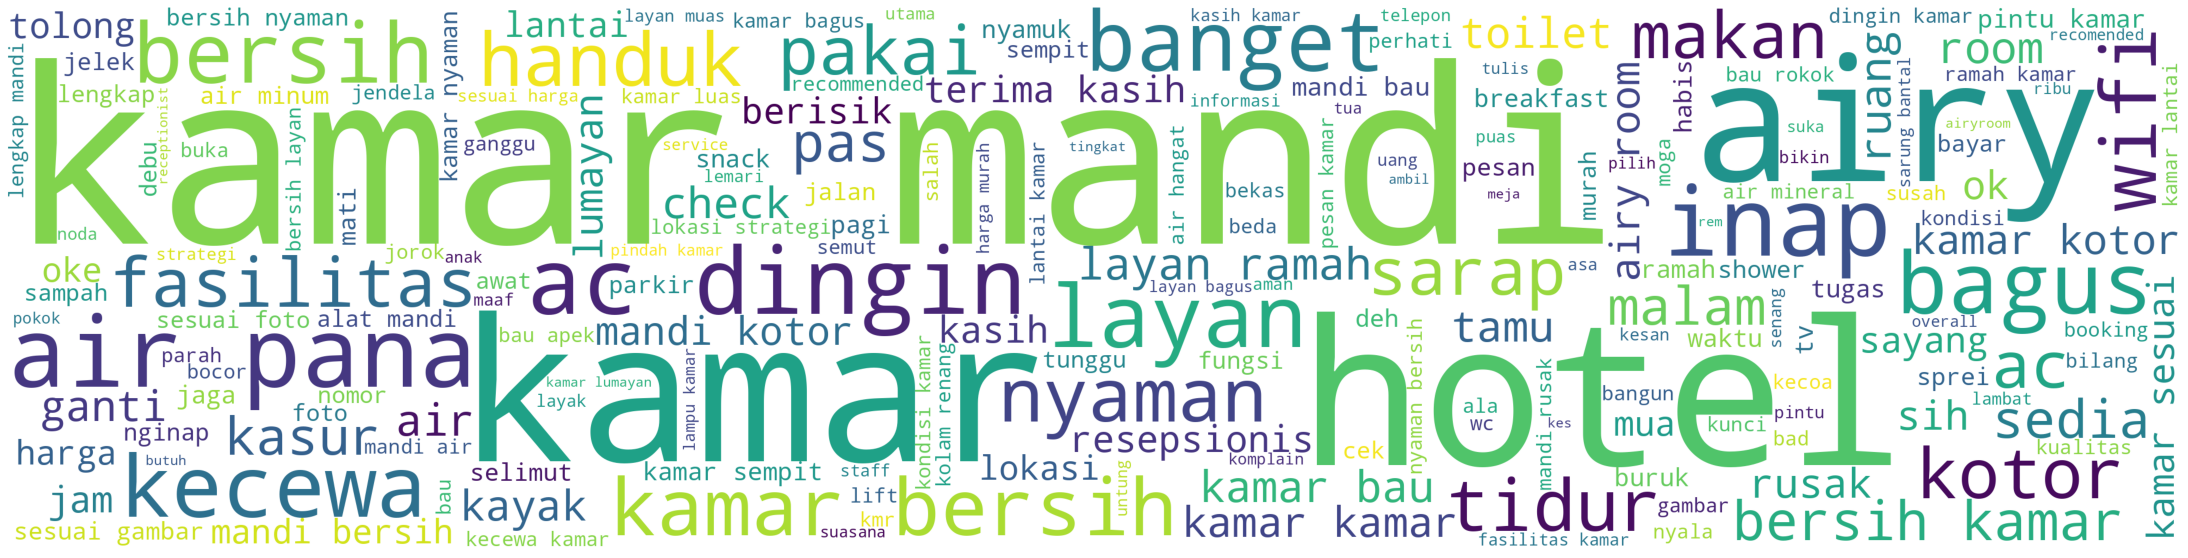

In [121]:
# wordcloud total
from wordcloud import WordCloud

all_data = df_train['review'].tolist()
all_data.extend(df_test['review'].tolist())

all_data_str = ' '.join(all_data)

wordcloud = WordCloud(background_color='white', width=4000, height=1000).generate(all_data_str)
plt.figure(figsize=(40,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

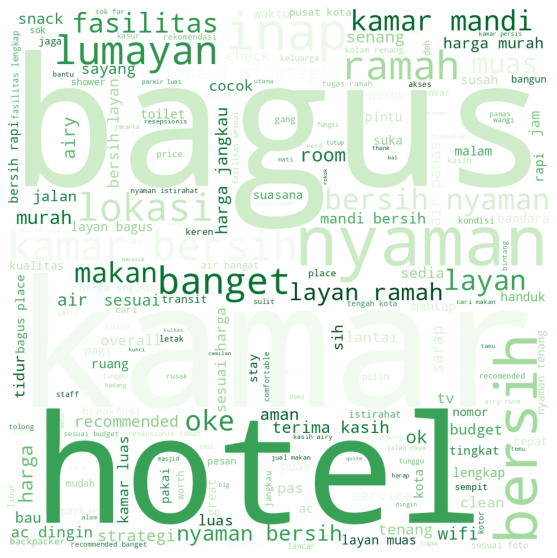

In [134]:
# wordcloud positive
pos_data = df_train[df_train['jenis_review'] == 1]["review"].tolist()
pos_data_str = ' '.join(pos_data)

wordcloud = WordCloud(colormap='Greens',
                      background_color='white',
                      width=1000,
                      height=1000).generate(pos_data_str)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

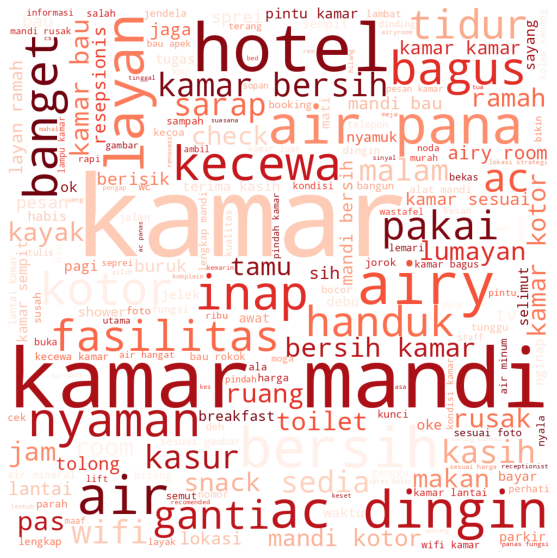

In [135]:
# wordcloud negative
neg_data = df_train[df_train['jenis_review'] == 0]["review"].tolist()
neg_data_str = ' '.join(neg_data)

wordcloud = WordCloud(colormap='Reds',
                      background_color='white',
                      width=1000,
                      height=1000).generate(neg_data_str)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Feature Extraction

In [172]:
X = df_train['review']
y = df_train['jenis_review']

In [173]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, use_idf=True)
X = vec.fit_transform(X)
print(X.shape)

(11142, 1549)


In [174]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Modeling

In [180]:
# Logistic Regression
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
model_LR = LogisticRegression(C=10.0, max_iter=1000)

model_LR.fit(X_train, y_train)
y_pred_LR = model_LR.predict(X_test)

f1_score(y_test, y_pred_LR, average='macro')

0.8008521308073627

In [191]:
# SVC
from sklearn.svm import SVC
model_SVC = SVC(C=10.0, gamma=0.1, kernel='rbf')
model_SVC.fit(X_train, y_train)
y_pred_SVC = model_SVC.predict(X_test)

f1_score(y_test, y_pred_SVC, average='macro')

0.8185222435703988

In [184]:
# XGBoost Classifier
from xgboost import XGBClassifier
model_XGB = XGBClassifier(n_estimators=1000, learning_rate=0.1, max_depth=5, n_jobs=-1)
model_XGB.fit(X_train, y_train)
y_pred_XGB = model_XGB.predict(X_test)

f1_score(y_test, y_pred_XGB, average='macro')

[12:32:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8113734450368114

In [189]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
model_KNN = KNeighborsClassifier(n_neighbors=5)
model_KNN.fit(X_train, y_train)
y_pred_KNN = model_KNN.predict(X_test)

f1_score(y_test, y_pred_KNN, average='macro')

0.6375235538576702

In [194]:
# Catboost Classifier
from catboost import CatBoostClassifier
model_cat = CatBoostClassifier(iterations=5000, learning_rate=0.01, depth=5, loss_function='Logloss')
model_cat.fit(X_train, y_train)
y_pred_cat = model_cat.predict(X_test)

f1_score(y_test, y_pred_cat, average='macro')

0:	learn: 0.6847408	total: 10.7ms	remaining: 53.4s
1:	learn: 0.6770894	total: 21.1ms	remaining: 52.8s
2:	learn: 0.6692145	total: 31.7ms	remaining: 52.8s
3:	learn: 0.6627134	total: 41.6ms	remaining: 52s
4:	learn: 0.6553331	total: 58.9ms	remaining: 58.9s
5:	learn: 0.6481310	total: 68.1ms	remaining: 56.7s
6:	learn: 0.6412183	total: 78ms	remaining: 55.6s
7:	learn: 0.6334856	total: 87.7ms	remaining: 54.7s
8:	learn: 0.6271539	total: 97.3ms	remaining: 53.9s
9:	learn: 0.6202366	total: 107ms	remaining: 53.4s
10:	learn: 0.6140157	total: 116ms	remaining: 52.7s
11:	learn: 0.6072260	total: 126ms	remaining: 52.2s
12:	learn: 0.6015262	total: 135ms	remaining: 51.7s
13:	learn: 0.5958158	total: 143ms	remaining: 51.1s
14:	learn: 0.5892449	total: 154ms	remaining: 51.1s
15:	learn: 0.5834062	total: 164ms	remaining: 51s
16:	learn: 0.5775196	total: 173ms	remaining: 50.8s
17:	learn: 0.5721861	total: 182ms	remaining: 50.4s
18:	learn: 0.5669925	total: 191ms	remaining: 50.1s
19:	learn: 0.5616157	total: 201ms	rema

0.778149038119748

In [206]:
# SGD Classifier
from sklearn.linear_model import SGDClassifier
model_SGD = SGDClassifier(loss='log', penalty='l2', alpha=0.00001, max_iter=1000)
model_SGD.fit(X_train, y_train)
y_pred_SGD = model_SGD.predict(X_test)

f1_score(y_test, y_pred_SGD, average='macro')

0.8006595020816367

In [211]:
print(f"""

    Model               | F1 Score (macro)
    :------------------:| :-----------------:
    Logistic Regression | {f1_score(y_test, y_pred_LR, average='macro')}
    SVC                 | {f1_score(y_test, y_pred_SVC, average='macro')}
    XGBoost             | {f1_score(y_test, y_pred_XGB, average='macro')}
    KNN                 | {f1_score(y_test, y_pred_KNN, average='macro')}
    Catboost            | {f1_score(y_test, y_pred_cat, average='macro')}
    SGD                 | {f1_score(y_test, y_pred_SGD, average='macro')}
    """)



    Model               | F1 Score (macro)
    :------------------:| :-----------------:
    Logistic Regression | 0.8008521308073627
    SVC                 | 0.8185222435703988
    XGBoost             | 0.8113734450368114
    KNN                 | 0.6375235538576702
    Catboost            | 0.778149038119748
    SGD                 | 0.8006595020816367
    


# SVC Hyperparameter Tuning 

In [224]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}
grid_LR = GridSearchCV(SVC(),
                    param_grid,
                    refit=True,
                    verbose=4,
                    scoring='f1_macro')
grid_LR.fit(X, y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.527 total time=   1.7s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.540 total time=   1.8s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.519 total time=   1.8s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.513 total time=   1.7s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.518 total time=   1.7s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.464 total time=   1.5s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.464 total time=   1.5s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.464 total time=   1.5s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.464 total time=   1.4s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.464 total time=   1.4s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.464 total time=   1.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='f1_macro', verbose=4)

In [225]:
print(f"""
Best F1 Score : {grid_LR.best_score_}
Best Parameters : {grid_LR.best_params_}
""")


Best F1 Score : 0.8183678606801766
Best Parameters : {'C': 10, 'gamma': 1, 'kernel': 'rbf'}



In [226]:
final_model = grid_LR.best_estimator_
final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)

f1_score(y_test, y_pred_final, average='macro')

0.8232109298306354

# Submission

In [227]:
df_test.head()

,id,review
0,263aqhh4ymyaubmb,tv rusak kamar mandi bersih
1,36frqq1ne0ljsgtj,sok bad really bad very bad bad and bad recept...
2,4dbq2twnu8nd9ztm,kecewa kamar lantai kamar licin tengah malam a...
3,hbsb134diyefkd3i,shower fungsi
4,o068bc8hfiisuwon,privasi minim suara kamar tetangga aula utama ...


In [228]:
X_test_submission = vec.transform(df_test['review'])
X_test_submission.shape

(3714, 1549)

In [232]:
y_pred_submission = final_model.predict(X_test_submission)
df_submission = pd.DataFrame({'id': df_test['id'], 'label': y_pred_submission})

In [237]:
df_submission.to_csv('hasil/submission.csv', index=False)

In [238]:
df_pembanding = pd.read_csv('../data/test.csv')
df_pembanding["label"] = y_pred_submission

df_pembanding.to_csv('hasil/pembanding.csv', index=False)

In [239]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3714 entries, 0 to 3713
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3714 non-null   object
 1   label   3714 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 58.2+ KB


# Coba di sampling

In [240]:
df_train.head()

,id,review,jenis_review
0,mnac5vg0i3mp5bdp,proses check cepat kemarin tunggu jam an pas c...,0
1,1y7m90hp3wwok7fm,kamar sesuai bekas bocor langit seprei lusuh k...,0
2,suvdvwh580hmj8nz,wifi aktif pakai lambat tolong wifi biar langs...,1
3,t07ma1ie3w29kqzy,breakfast kontrol makan habis bersih kamar hot...,0
4,jcwq3gfdryrdbdx5,layan ramah colok air nyamuk sarang lemari,0


<AxesSubplot:>

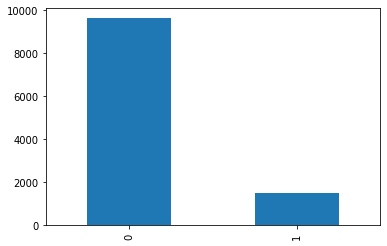

In [247]:
df_train["jenis_review"].value_counts().plot(kind='bar')

<AxesSubplot:>

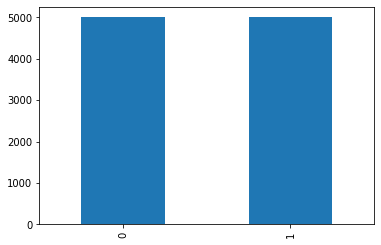

In [248]:
s_0 = df_train[df_train["jenis_review"]==0].sample(5000, replace=True)
s_1 = df_train[df_train["jenis_review"] == 1].sample(5000, replace=True)

df_train_sampled = pd.concat([s_0, s_1])
df_train_sampled["jenis_review"].value_counts().plot(kind='bar')

In [249]:
X_sampled = vec.fit_transform(df_train_sampled['review'])
y_sampled = df_train_sampled['jenis_review']

X_train_sampled, X_test_sampled, y_train_sampled, y_test_sampled= train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled)

In [250]:
final_model_sampled = grid_LR.best_estimator_
final_model_sampled.fit(X_train_sampled, y_train_sampled)
y_pred_final_sampled = final_model_sampled.predict(X_test_sampled)

f1_score(y_test_sampled, y_pred_final_sampled, average='macro')

0.96498988207592

In [251]:
df_test.head()

,id,review
0,263aqhh4ymyaubmb,tv rusak kamar mandi bersih
1,36frqq1ne0ljsgtj,sok bad really bad very bad bad and bad recept...
2,4dbq2twnu8nd9ztm,kecewa kamar lantai kamar licin tengah malam a...
3,hbsb134diyefkd3i,shower fungsi
4,o068bc8hfiisuwon,privasi minim suara kamar tetangga aula utama ...


In [252]:
X_test_submission_sampled = vec.transform(df_test['review'])
X_test_submission_sampled.shape

(3714, 1674)

In [253]:
y_pred_submission_sampled = final_model.predict(X_test_submission_sampled)
df_submission_sampled = pd.DataFrame({
    'id': df_test['id'],
    'label': y_pred_submission_sampled
})
df_submission_sampled.to_csv('hasil/submission_sampled.csv', index=False)

In [254]:
df_pembanding_sampled = pd.read_csv('../data/test.csv')
df_pembanding_sampled["label"] = y_pred_submission_sampled
df_pembanding_sampled.to_csv('hasil/pembanding_sampled.csv', index=False)